<a href="https://colab.research.google.com/github/frozentraitor/dynamicGraphs/blob/main/evo_nodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
    pip install node2vec

In [ ]:
import os
import networkx as nx

# Define the folder path
folder_path = '/content/drive/MyDrive/NLP/as-11/'# change the file name as neededn eg:as-11 or as-2

# Initialize a list to store graphs
graph_list = []

# Iterate over each text file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        # Read the graph data from the file
        file_path = os.path.join(folder_path, filename)
        G = nx.Graph()
        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith('#'):
                    continue
                parts = line.split()
                if len(parts) == 2:
                    from_node, to_node = map(int, parts)
                    # Add the edge only if it doesn't already exist
                    if not G.has_edge(from_node, to_node):
                        G.add_edge(from_node, to_node)
        # Append the graph to the list
        graph_list.append(G)

# Print the number of graphs created
print(f"Number of graphs created: {len(graph_list)}")


Number of graphs created: 11


In [ ]:
# Keep only the first 4 graphs
graph_list = graph_list[:4]

# Print the number of graphs after trimming
print(f"Number of graphs after trimming: {len(graph_list)}")

Number of graphs after trimming: 4


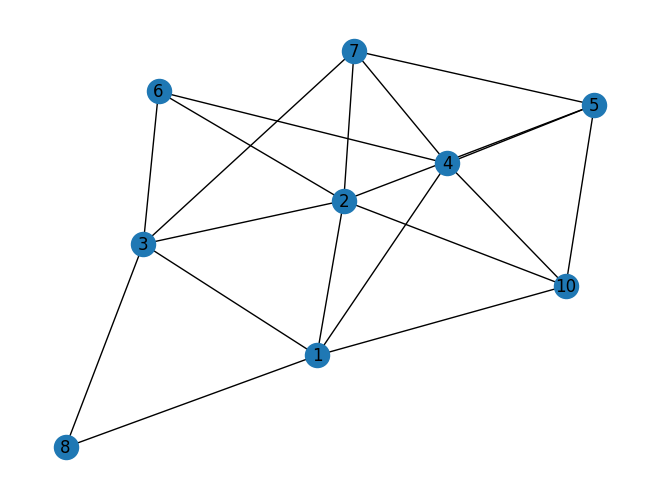

In [ ]:
import matplotlib.pyplot as plt

nx.draw(graph_list[1], with_labels=True)
plt.show()

In [ ]:
import os
import networkx as nx
from node2vec import Node2Vec
from gensim.models import Word2Vec
import numpy as np
import random

# Parameters
dimensions = 128
walk_length = 5
num_walks = 10
window_size = 5
workers = 8
p = 1.0
q = 1.0
initial_alpha = 0.025  # Initial learning rate
min_alpha = 0.0001     # Minimum learning rate

# Ensure graph_list has at least 2 graphs
if len(graph_list) < 2:
    raise ValueError("graph_list must contain at least 2 graphs for training and evaluation.")

# Step 1: Static Node2Vec for initial embedding
G1 = graph_list[0]
node2vec = Node2Vec(G1, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, p=p, q=q, workers=workers)
# model = node2vec.fit()
model = node2vec.fit(window=window_size, min_count=1, batch_words=4)

# Get initial embeddings Z1
Z1 = {str(node): model.wv[str(node)] for node in G1.nodes()}  # Embedding vectors Z1
current_alpha = initial_alpha  # Initialize current learning rate
alpha_decay = (initial_alpha - min_alpha) / (len(graph_list) - 1)

# Function to identify evolving nodes
def find_evolving_nodes(G_prev, G_curr):
    V_add = set(G_curr.nodes()).difference(set(G_prev.nodes()))
    E_add = set(G_curr.edges()).difference(set(G_prev.edges()))
    E_del = set(G_prev.edges()).difference(set(G_curr.edges()))
    delta_Vt = V_add.union({v for (u, v) in E_add.union(E_del) if u in G_curr.nodes()})
    return delta_Vt

def find_evolving_nodes_with_neighbors(G_prev, G_curr, max_depth=3):
    V_add = set(G_curr.nodes()).difference(set(G_prev.nodes()))
    E_add = set(G_curr.edges()).difference(set(G_prev.edges()))
    E_del = set(G_prev.edges()).difference(set(G_curr.edges()))
    delta_Vt = V_add.union({v for (u, v) in E_add.union(E_del) if u in G_curr.nodes()})

    # Find up to max_depth neighbors of nodes in delta_Vt
    neighbors = set(delta_Vt)  # Start with delta_Vt itself
    for _ in range(2):# change the number to change the nearest neighboure considered
        new_neighbors = set()
        for node in neighbors:
            if node in G_curr.nodes():
                new_neighbors.update(G_curr.neighbors(node))
        neighbors.update(new_neighbors)

    return neighbors


# Custom walk generation for evolving nodes
def generate_evolving_walks(graph, nodes, num_walks, walk_length):
    walks = []
    for _ in range(num_walks):
        for node in nodes:
            if node in graph.nodes():  # Check if the node is in the graph
                # walk = [node]
                walk = [str(node)]
                while len(walk) < walk_length:
                    cur = walk[-1]
                    # neighbors = list(graph.neighbors(cur))
                    neighbors = list(graph.neighbors(int(cur)))
                    if neighbors:
                        # walk.append(random.choice(neighbors))
                        walk.append(str(random.choice(neighbors)))
                    else:
                        break
                walks.append(walk)
    return walks


# Step 2: Process the second graph (only if there are exactly 2 graphs)
# if len(graph_list) == 2:
#     Gt_minus_1 = graph_list[0]
#     Gt = graph_list[1]

#     print(f"Processing graph 2/{len(graph_list)}")

#     # Evolving nodes between G1 and G2
#     evolving_nodes = find_evolving_nodes_with_neighbors(Gt_minus_1, Gt)
#     # evolving_nodes = find_evolving_nodes(Gt_minus_1, Gt)

#     # Print evolving nodes
#     print(f"Evolving nodes for graph 2: {evolving_nodes}")

#     evolving_walks = generate_evolving_walks(Gt, evolving_nodes, num_walks, walk_length)
#     print(f"Evolving walks: {evolving_walks[:2]}")

for t in range(1, len(graph_list)-1 ):  # Iterate through the first n-1 time steps
      Gt_minus_1 = graph_list[t-1]
      Gt = graph_list[t]

      # Find evolving nodes
      evolving_nodes = find_evolving_nodes_with_neighbors(Gt_minus_1, Gt)
      # evolving_nodes = find_evolving_nodes(Gt_minus_1, Gt)
      print(f"Evolving nodes: {evolving_nodes}")

      # Generate evolving walks
      evolving_walks = generate_evolving_walks(Gt, evolving_nodes, num_walks, walk_length)
      print(f"Evolving walkzs: {evolving_walks[:2]}")  # Print first 5 walks for brevity

      # Train Skip-gram model on evolving walks
      skipgram_model = Word2Vec(sentences=evolving_walks, vector_size=dimensions, window=window_size, min_count=1, sg=1, workers=workers)

      # Get embeddings for evolving nodes (only those present in the model's vocabulary)
      Z_evolving = {str(node): skipgram_model.wv[str(node)] for node in evolving_nodes if str(node) in skipgram_model.wv}

      Z1.update(Z_evolving)

      # Print Z_evolving
      # print(Z_evolving);




Computing transition probabilities:   0%|          | 0/3213 [00:00<?, ?it/s]

Evolving nodes: {1, 3, 6, 7, 8, 9, 13, 16, 17, 22, 25, 26, 27, 31, 32, 33, 34, 38, 41, 43, 45, 46, 48, 49, 50, 52, 55, 68, 70, 71, 72, 73, 74, 77, 80, 81, 83, 87, 88, 90, 93, 97, 99, 103, 109, 111, 114, 125, 127, 131, 132, 137, 140, 144, 145, 157, 159, 160, 163, 174, 175, 194, 195, 196, 199, 201, 204, 209, 210, 217, 224, 225, 226, 237, 266, 268, 270, 271, 278, 284, 286, 288, 291, 292, 293, 297, 298, 299, 302, 376, 377, 400, 423, 450, 454, 456, 466, 488, 489, 509, 513, 517, 523, 549, 552, 555, 557, 559, 565, 568, 577, 600, 613, 625, 636, 655, 668, 679, 681, 683, 684, 685, 686, 687, 693, 700, 701, 702, 703, 705, 714, 715, 719, 721, 724, 744, 745, 762, 763, 764, 766, 772, 786, 789, 790, 800, 803, 812, 813, 814, 815, 816, 817, 831, 834, 838, 839, 852, 854, 855, 1103, 1129, 1133, 1136, 1138, 1140, 1198, 1200, 1201, 1206, 1213, 1220, 1221, 1224, 1225, 1226, 1227, 1236, 1237, 1238, 1239, 1241, 1248, 1251, 1254, 1257, 1262, 1263, 1267, 1270, 1273, 1275, 1276, 1280, 1290, 1292, 1299, 1312, 1321

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Function to predict link existence using dot product of node embeddings
def predict_link(u, v, embeddings):
    if str(u) in embeddings and str(v) in embeddings:
        return np.dot(embeddings[str(u)], embeddings[str(v)])
    else:
        return 0  # If either node is not in embeddings, return 0 as prediction

# Calculate AUC score for link prediction
def calculate_auc_score(graph, embeddings):
    y_true = []
    y_scores = []

    # Positive examples (existing edges)
    for edge in graph.edges():
        u, v = edge
        y_true.append(1)
        y_scores.append(predict_link(u, v, embeddings))

    # Negative examples (non-existing edges)
    non_edges = nx.non_edges(graph)
    for u, v in random.sample(list(non_edges), len(graph.edges())):
        y_true.append(0)
        y_scores.append(predict_link(u, v, embeddings))

    # Calculate AUC score
    auc_score = roc_auc_score(y_true, y_scores)
    return auc_score, y_true, y_scores

# Get the last graph from the graph_list
Gt_last = graph_list[-1]

# Calculate AUC score for the last graph
auc_score, y_true, y_scores = calculate_auc_score(Gt_last, Z1)
print(f"AUC Score for link prediction in the last graph: {auc_score}")


AUC Score for link prediction in the last graph: 0.9212855397338096


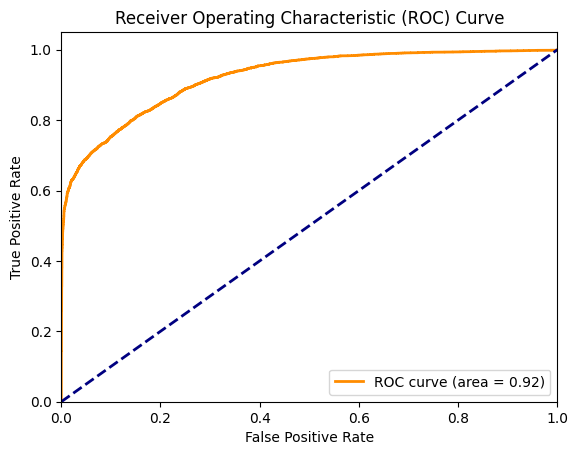

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Assuming you have y_true and y_scores from calculate_auc_score
plot_roc_curve(y_true, y_scores)


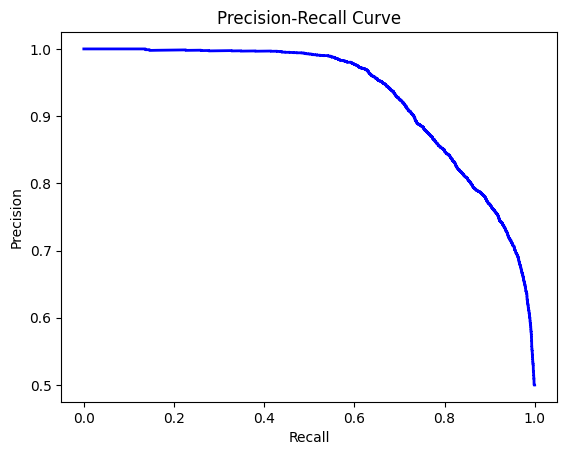

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

plot_precision_recall_curve(y_true, y_scores)


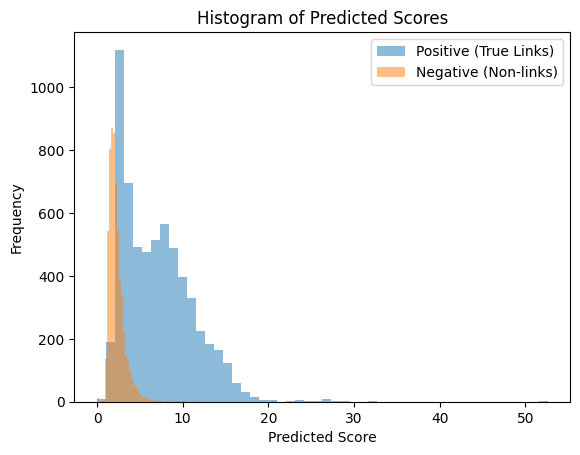

In [ ]:
def plot_score_histograms(y_true, y_scores):
    pos_scores = [score for true, score in zip(y_true, y_scores) if true == 1]
    neg_scores = [score for true, score in zip(y_true, y_scores) if true == 0]

    plt.figure()
    plt.hist(pos_scores, bins=50, alpha=0.5, label='Positive (True Links)')
    plt.hist(neg_scores, bins=50, alpha=0.5, label='Negative (Non-links)')
    plt.xlabel('Predicted Score')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Scores')
    plt.legend(loc='upper right')
    plt.show()

plot_score_histograms(y_true, y_scores)
